In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import os
from keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

# Loading the data

Load the dataset. For this, you can use your own custom dataset. In this blog, we are going to use the skin cancer dataset binary classification benign vs malignant. After that we need to label.

In [2]:
train_dir='C:/Users/Chadha/OneDrive/Bureau/3 DNI_S1/computer_vision/TP3/archive/train'
Labels = ['benign', 'malignant']
print ("class : ") 
for i in range(len(Labels)): 
    print (i, end = " ") 
    print (Labels[i])

class : 
0 benign
1 malignant


In [3]:
print('Number of classes:',len(Labels))

Number of classes: 2


# Transfer Learning with TensorFlow hub

Select the Hub/TF2 module to use, you have a choice with inception v3 or Mobilenet.In the blog we are using MobileNet model.

In [17]:

module_selection = ("mobilenet_v2", 224, 1280) #efficientnet 
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/2".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
BATCH_SIZE = 16 

"""
module_selection = ("efficientnet_v2", 224, 1280)
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet/feature_vector/2"
IMAGE_SIZE = (pixels, pixels)
BATCH_SIZE = 16
"""


# Data Preprocessing

Set up data generators to read images from our source folders, transform them to float32 tensors, and feed them to our network (along with their labels). As you may be aware, data that is fed into neural networks is normally normalised in some way to make it easier for the network to process.

In our situation, we’ll preprocess our images by converting the pixel values to the [0, 1] range (all values are now in the [0, 255] range). The input data must be scaled to 224×224 pixels as an input, as specified by the networks. You can choose whether or not to use image augmentation.

In [18]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      fill_mode='nearest',
      validation_split=0.3)
  
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

validation_generator = train_datagen.flow_from_directory(
    train_dir, 
    shuffle=False, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    subset="validation",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

Found 1846 images belonging to 2 classes.
Found 791 images belonging to 2 classes.


# Q2: Build the model

In [19]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,input_shape=IMAGE_SIZE+(3,), output_shape=[FV_SIZE])ù
#fine tuning: 
do_fine_tuning = False 
if do_fine_tuning:
  feature_extractor.trainable = True
  for layer in base_model.layers[-30:]: # à partir layer 30 on vas conserver ces derniers layers pour fine tuning
    layer.trainable =True
  
else:
  feature_extractor.trainable = False

print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),  #technique de régularisation pour évier le overfitting
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])

model.summary()

HTTPError: HTTP Error 404: Not Found

# Training Model


Validate each step by training the model with the validation dataset. We achieve 81% accuracy after 15 epochs, but fine-tuning can increase this to more.

In [ ]:
LEARNING_RATE = 0.001 
model.compile(
   optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
   loss='categorical_crossentropy',
   metrics=['accuracy'])

In [8]:
EPOCHS=15
history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size)

Epoch 1/15
115/115 [==============================] - 56s 437ms/step - loss: 0.5057 - accuracy: 0.7902 - val_loss: 0.4490 - val_accuracy: 0.8023
Epoch 2/15
115/115 [==============================] - 50s 437ms/step - loss: 0.3417 - accuracy: 0.8464 - val_loss: 0.5271 - val_accuracy: 0.7538
Epoch 3/15
115/115 [==============================] - 51s 441ms/step - loss: 0.3261 - accuracy: 0.8579 - val_loss: 0.5406 - val_accuracy: 0.7628
Epoch 4/15
115/115 [==============================] - 51s 441ms/step - loss: 0.3060 - accuracy: 0.8563 - val_loss: 0.5672 - val_accuracy: 0.7385
Epoch 5/15
115/115 [==============================] - 51s 445ms/step - loss: 0.3056 - accuracy: 0.8656 - val_loss: 0.5404 - val_accuracy: 0.7207
Epoch 6/15
115/115 [==============================] - 63s 548ms/step - loss: 0.2884 - accuracy: 0.8732 - val_loss: 0.4806 - val_accuracy: 0.7755
Epoch 7/15
115/115 [==============================] - 54s 473ms/step - loss: 0.2748 - accuracy: 0.8749 - val_loss: 0.4754 - val_ac

# Checking Performance

Plot training and validation, accuracy and loss

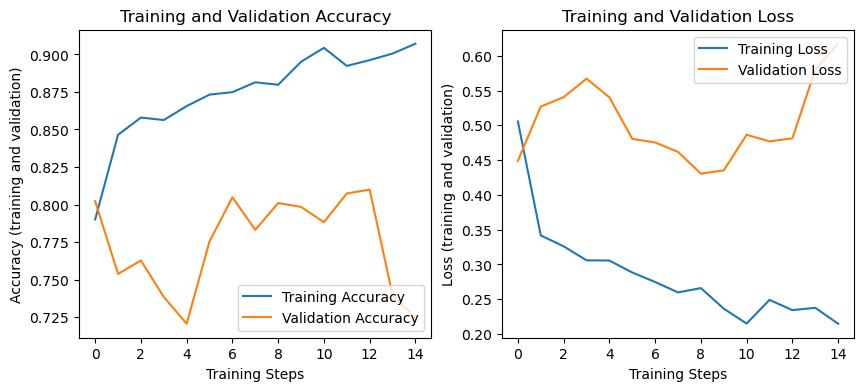

In [9]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

# Test at random

Pick five images at random from the validation dataset and make the following prediction

1/1 [==============================] - 1s 571ms/step
class: malignant, confidence: 0.982812


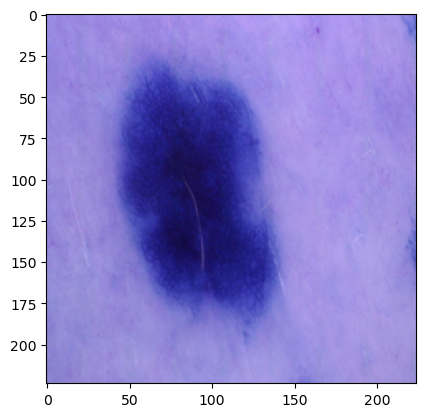

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 45ms/step
class: benign, confidence: 0.782218


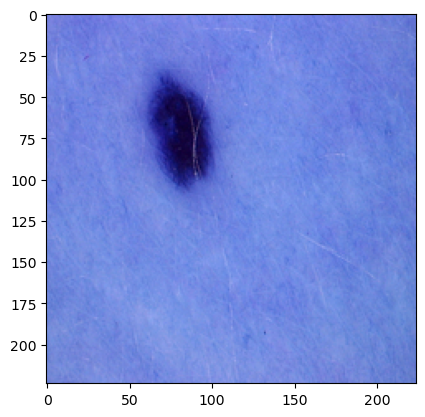

1/1 [==============================] - 0s 45ms/step
class: benign, confidence: 0.987944


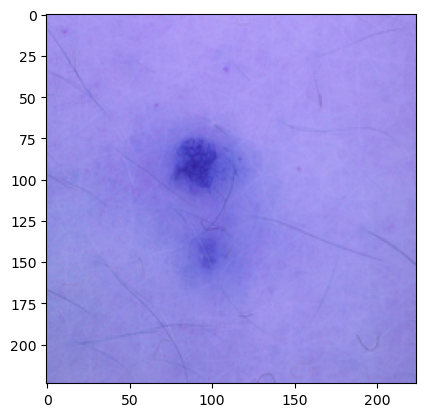

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 42ms/step
class: malignant, confidence: 0.863261


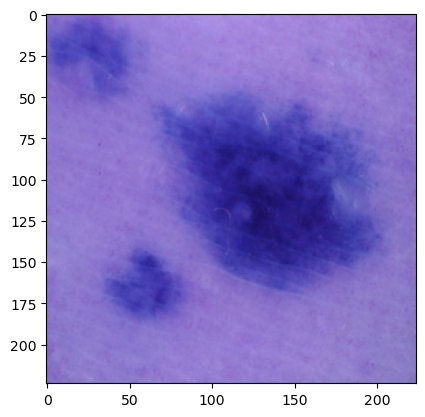

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 43ms/step
class: benign, confidence: 0.843333


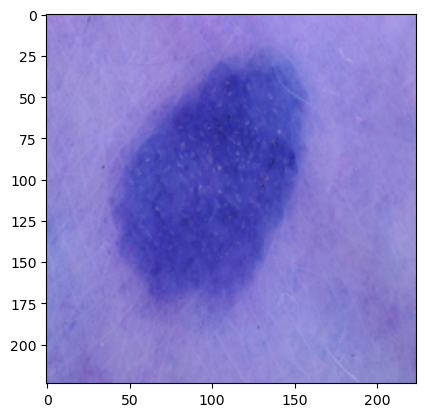

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 41ms/step
class: benign, confidence: 0.518836


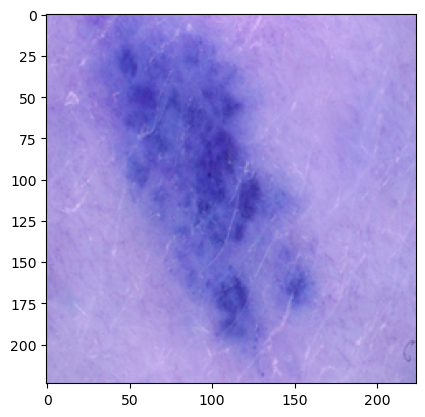

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 42ms/step
class: benign, confidence: 0.821024


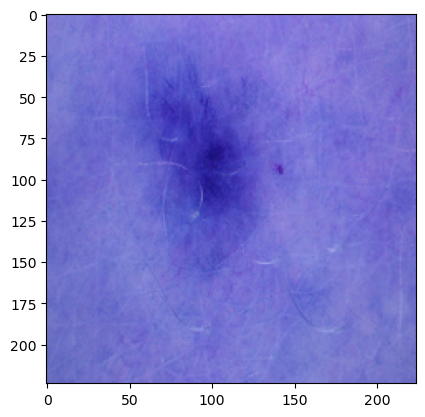

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 45ms/step
class: malignant, confidence: 0.853165


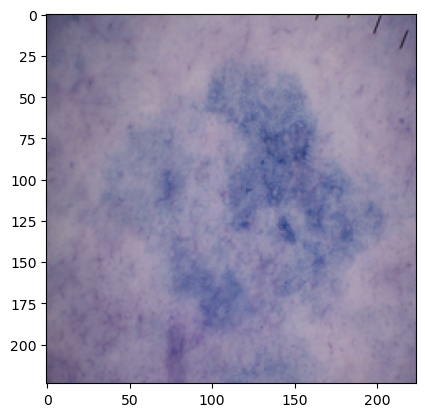

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 43ms/step
class: benign, confidence: 0.936253


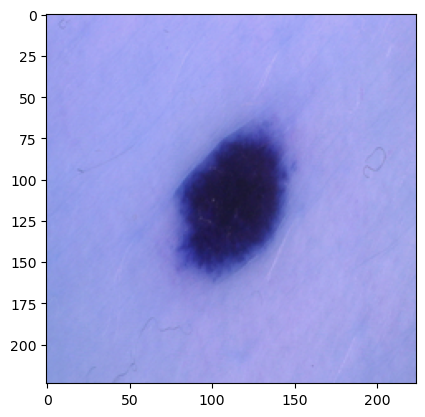

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 44ms/step
class: benign, confidence: 0.756657


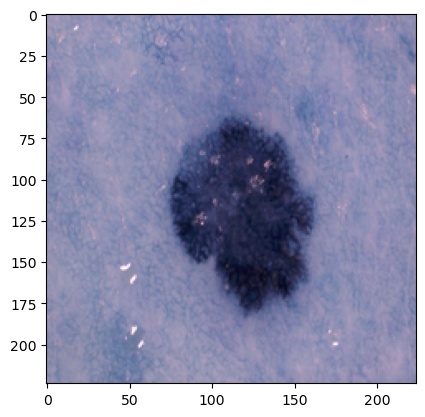

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 41ms/step
class: malignant, confidence: 0.544553


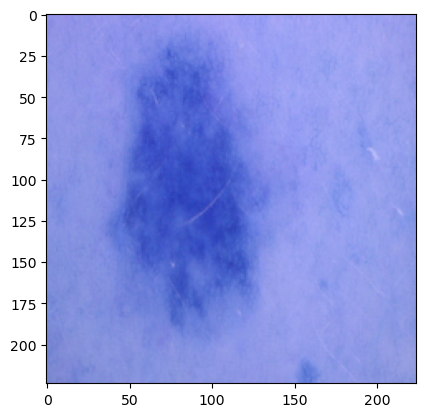

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 43ms/step
class: benign, confidence: 0.634242


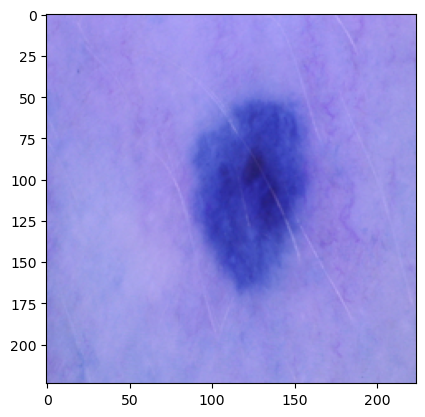

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 43ms/step
class: benign, confidence: 0.582133


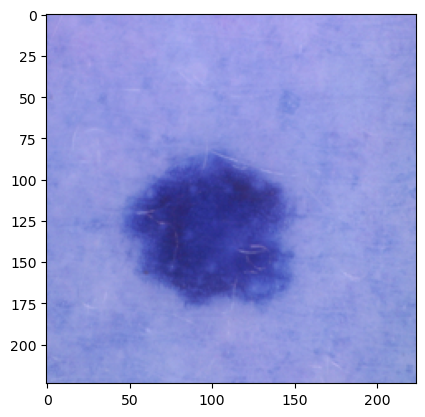

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 39ms/step
class: benign, confidence: 0.747752


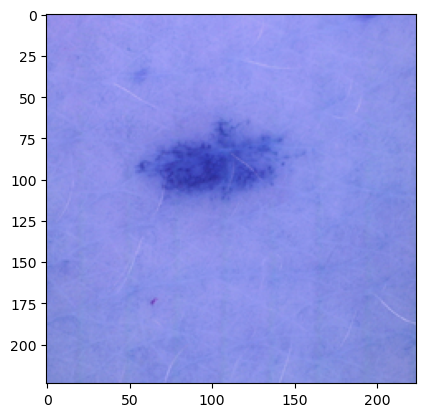

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 41ms/step
class: benign, confidence: 0.554461


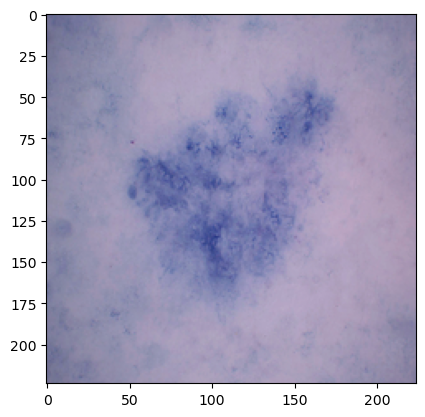

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 45ms/step
class: malignant, confidence: 0.856348


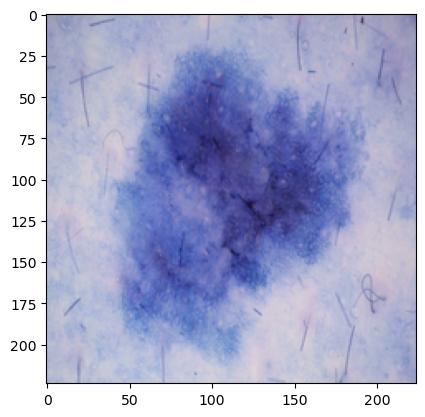

<Figure size 640x480 with 0 Axes>

In [10]:
import random
import cv2
def upload(filename):
    img = cv2.imread(os.path.join(train_dir, filename))
    img = cv2.resize(img, (224, 224) )
    img = img /255
    return img

def pre_result(img):
    x = model.predict(np.asarray([img]))[0]
    classx = np.argmax(x)
    return {Labels[classx]: x[classx]}

images = random.sample(validation_generator.filenames, 16)

for idx, filename in enumerate(images):
    img = upload(filename)
    prediction = pre_result(img)
    print("class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

# Confusion Matrix

1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 42ms/step
Confusion Matrix


<Axes: >

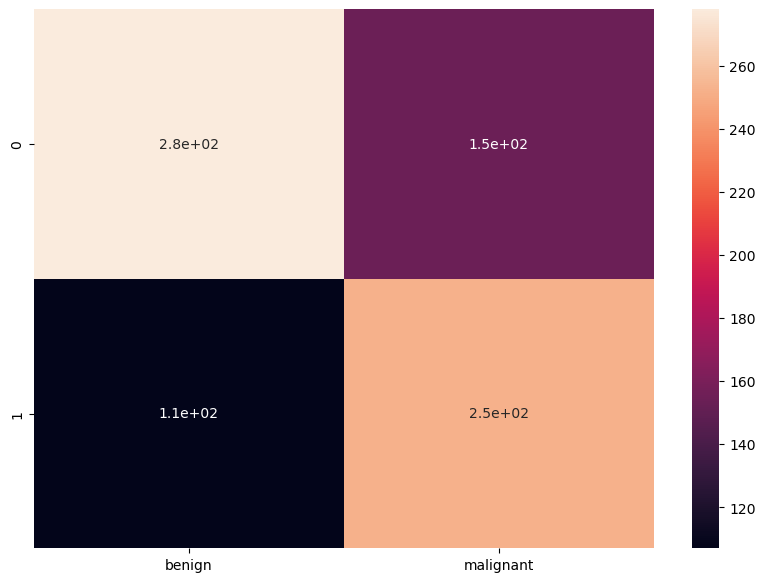

In [11]:
import pandas as pd
import numpy as np
import seaborn as sn
from sklearn.metrics import confusion_matrix

y = np.zeros(len(validation_generator.filenames))
# compute predicted labels y
for idx, filename in enumerate(validation_generator.filenames):
    img = upload(filename)
    prediction = pre_result(img)
    y[idx] = list(prediction.keys())[0] == "malignant"

print('Confusion Matrix')
cm = confusion_matrix(validation_generator.classes, y)
df = pd.DataFrame(cm, columns=validation_generator.class_indices)
plt.figure(figsize=(10,7))
sn.heatmap(df, annot=True)

Export as saved model and convert to TFLite:

In [16]:
import time
t = time.time()
export_path = "/tmp/saved_models/{}".format(int(t))
tf.keras.models.save_model(model, export_path)
export_path

INFO:tensorflow:Assets written to: /tmp/saved_models/1699949749\assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1699949749\assets


'/tmp/saved_models/1699949749'

In [13]:
# Now confirm that we can reload it, and it still gives the same results
reloaded = tf.keras.models.load_model(export_path, custom_objects={'KerasLayer':hub.KerasLayer})
def predict_reload(image):
    probabilities = reloaded.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    return {Labels[class_idx]: probabilities[class_idx]}

SOURCE: class: benign, file: benign\1389.jpg
1/1 [==============================] - 0s 491ms/step
PREDICTED: class: benign, confidence: 0.668723


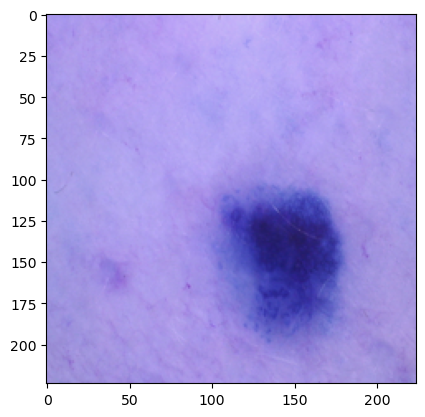

<Figure size 640x480 with 0 Axes>

SOURCE: class: benign, file: benign\13.jpg
1/1 [==============================] - 0s 43ms/step
PREDICTED: class: benign, confidence: 0.999552


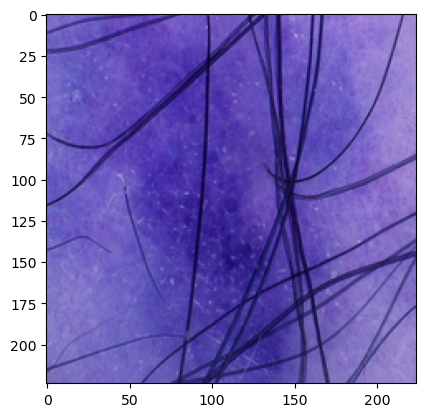

In [14]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 2)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    img = upload(filename)
    prediction = predict_reload(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

In [15]:
# convert the model to TFLite
!mkdir "tflite_models"
TFLITE_MODEL = "tflite_models/model.tflite"

# Get the concrete function from the Keras model.
run_model = tf.function(lambda x : reloaded(x))

# Save the concrete function.
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
)
# Convert the model to standard TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)

11542820